<a href="https://colab.research.google.com/github/talestrom/nTARPclassification/blob/main/cube_model_nTARP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test classification on multiple setting of the stretched cube model and compare the results for n-TARP, logit and SVM.

In [ ]:
import numpy as np
from scipy.special import comb
import scipy.special as sc
from scipy.stats import beta
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import math
import skimage
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import bernoulli, binom
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
from sklearn.svm import LinearSVC
from sklearn import preprocessing

Function that classifies datasets using n-TARP method based on r random projections:

In [ ]:
def nTARP_class_fit(X, Y, r):
  (m,n) = X.shape; #n is the dimension of points to separate into clusters, m is the number of points
  W = np.zeros(r); #vector of classification errors for r different random projections
  v = np.zeros((r,n))
  for i in range(r):
    for j in range(n):
      v[i,j] = np.random.normal(0,1) #populate v with random normal independent variables, without normalization to the unit hypersphere
  # Try random projection r times, find the optimal random vector and threshold
  rpvec = np.zeros(n)
  min_error = 1
  I=r+1
  idx_opt = np.zeros(m)
  P_min = np.zeros(m)
  for i in range(r):
    V = np.tile(v[i,:],(m,1)) #choosing the i-th random vector, replicating it m times
    P = np.sum((X*V),1) #projecting each point onto the i-th random vector
    clf = LogisticRegression(random_state=0).fit(P.reshape(-1,1), Y) #fitting logistic regression to the one-dim points
    W[i] = 1-clf.score(P.reshape(-1,1), Y) #error of regression
    if W[i]<min_error:
      min_error = W[i] #finding minimal error
      rpvec = v[i,:] #finding vector that gives the smallest error
      coef = clf.coef_[0,0]
      intercept = clf.intercept_[0]
      #thresh = -intercept/coef

  return min_error,rpvec,coef,intercept

Function that predicts a class for a new point based on the n-TARP classification:

In [ ]:
def nTARP_class_predict(X, rpvec, coef, intercept):
  (m,n) = X.shape; #n is the dimension of points to separate into clusters, m is the number of points
  Y = np.zeros(m) #prepare the vector that holds predicted classes
  for i in range(m):
    if coef*np.dot(X[i],rpvec)+intercept>0:
      Y[i]=1
  return Y

Function that generated data based on the "stretched cube model" (described in Section 4.1)

In [ ]:
def stretched_cube_model(d, sigma, p0, p1, s0, s1, r):
  #d is the dimension of data, sigma - standard deviation of noise, p0, p1 vector of parameters of Bernoulli for both classes (length d),
  #s0,s1 number ofsamples generated for each class, r is the stretching , 1<r<2 for no clusters in the original dimension. If r=1 we get a cube model (as a special case).
  X = np.zeros((s0+s1,d))
  Y = np.zeros(s0+s1)
  for i in range(s0):
    for j in range(d):
      if j==0:
        X[i,j] = bernoulli.rvs(p0[j]) + np.random.normal(0,sigma)
      if j>0:
        X[i,j] = np.sqrt(r**(j-1))*bernoulli.rvs(p0[j]) + np.random.normal(0,sigma)
      Y[i]=0
  for i in range(s0,s0+s1):
    for j in range(d):
      if j==0:
        X[i,j] = bernoulli.rvs(p1[j]) + np.random.normal(0,sigma)
      if j>0:
        X[i,j] = np.sqrt(r**(j-1))*bernoulli.rvs(p1[j]) + np.random.normal(0,sigma)
      Y[i]=1
  return X,Y

Gererate data using stretched_cube_model(d, sigma, p0, p1, s0, s1, r)

In [ ]:
d = 6
sigma = 0
s0 = 10
s1 = 5
r = float(1) # need to add float here, otherwise can not take square root
#print(type(r))
p0 = np.ones(d)
p1 =np.ones(d)
for i in range(d-int(d/2)):
  p0[i]=0.25
for i in range(d-int(d/2),d):
  p0[i]=0.8
p0[d-1]=1
for i in range(d-int(d/2)):
  p1[i]=0.65
for i in range(d-int(d/2),d):
  p1[i]=0.45
p1[d-1]=1

X,Y = stretched_cube_model(d,sigma,p0,p1,s0,s1,r)

shuffle the data:

In [ ]:
from sklearn.utils import shuffle
X,Y = shuffle(X,Y)
X_train, Y_train = X, Y

In [ ]:
#generate test data:
X_test,Y_test = stretched_cube_model(d,sigma,p0,p1,1000,500,r)
X_test, Y_test = shuffle(X_test, Y_test)

Classify using logistic regression:

In [ ]:
#Logistic regression result:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train) #fitting logistic regression to the points
train_error = 1-clf.score(X_train, Y_train) #train error of regression
test_error=np.sum(np.abs(Y_test-clf.predict(X_test)))/Y_test.size
print(train_error)
print(test_error)#test error of logistic regression
print(-train_error+test_error)

0.0
0.18866666666666668
0.18866666666666668


Classify using svm:

In [ ]:
#svm
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, Y_train)
train_error=np.sum(np.abs(clf.predict(X_train)-Y_train))/Y_train.size
test_error=np.sum(np.abs(clf.predict(X_test)-Y_test))/Y_test.size
print(train_error)
print(test_error)
print(-train_error+test_error)

0.0
0.192
0.192


Classify using n-TARP:

In [ ]:
min_error,rpvec,coef,intercept=nTARP_class_fit(X_train, Y_train, 10000)
train_error=min_error
print(min_error)
Y_predict = nTARP_class_predict(X_test, rpvec, coef,intercept)
test_error = np.sum(np.abs(Y_test-Y_predict))/Y_test.size
print(test_error)
print(test_error-train_error)

0.0
0.21933333333333332
0.21933333333333332


What happens to the errors when Bernoulli parameters of different classes get closer? Vary linearly  between A=(0.25,...,0.8,1) and F = (0.8,...,0.25,1).

In [ ]:
d = 65
sigma = 0.05
s0 = 100
s1 = 100
r = float(1) # need to add float here, otherwise can not take square root
p0 = np.zeros(d)
for i in range(d-int(d/2)):
  p0[i]=0.25
for i in range(d-int(d/2),d):
  p0[i]=0.8
p0[d-1]=1

Compare linear regression, SVM and n-TARP on the stretched cube data:

In [ ]:
#how does linear SVM behave compared to other models?
detail = 20
gap_logit=np.zeros(detail)
gap_logit_deviation = np.zeros(detail)
train_logit = np.zeros(detail)
#train_logit_deviation = np.zeros(detail)
test_logit = np.zeros(detail)
#test_logit_deviation = np.zeros(detail)
gap_SVM=np.zeros(detail)
gap_SVM_deviation = np.zeros(detail)
train_SVM = np.zeros(detail)
#train_SVM_deviation = np.zeros(detail)
test_SVM = np.zeros(detail)
#test_SVM_deviation = np.zeros(detail)
gap_nTARP=np.zeros(detail)
gap_nTARP_deviation=np.zeros(detail)
train_nTARP=np.zeros(detail)
#train_nTARP_deviation=np.zeros(detail)
test_nTARP=np.zeros(detail)
#test_nTARP_deviation=np.zeros(detail)
gap_linear_SVM=np.zeros(detail)
gap_linear_SVM_deviation=np.zeros(detail)
train_linear_SVM=np.zeros(detail)
#train_linear_SVM_deviation=np.zeros(detail)
test_linear_SVM=np.zeros(detail)
#test_linear_SVM_deviation=np.zeros(detail)
for k in range(detail):
  p1 =np.zeros(d)
  for i in range(d-int(d/2)):
    p1[i]=p0[i]+k*(0.8-p0[i])/detail
  for i in range(d-int(d/2),d):
    p1[i]=p0[i]-k*(p0[i]-0.25)/detail
  p1[d-1]=1
  print(k)
  #print(p0,p1)
  repeat=5
  gap_logit_tries=np.zeros(repeat)
  gap_SVM_tries=np.zeros(repeat)
  gap_nTARP_tries=np.zeros(repeat)
  gap_linear_SVM_tries = np.zeros(repeat)
  for j in range(repeat):
    # generate training and testing data:
    X,Y = stretched_cube_model(d,sigma,p0,p1,s0,s1,r)
    X_train, Y_train = shuffle(X,Y)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test,Y_test = stretched_cube_model(d,sigma,p0,p1,1000,1000,r)
    X_test, Y_test = shuffle(X_test, Y_test)
    X_test_scaled = scaler.transform(X_test)
  #logit:
    clf = LogisticRegression().fit(X_train_scaled, Y_train) #fitting logistic regression to the points, rescaled
    train_error = 1-clf.score(X_train_scaled, Y_train) #train error of regression
    test_error = np.sum(np.abs(Y_test-clf.predict(X_test_scaled)))/Y_test.size
    train_logit[k]=train_logit[k]+train_error
    test_logit[k]=test_logit[k]+test_error
    gap_logit_tries[j]=np.abs(test_error-train_error)
  #SVM:
    clf2 = svm.SVC()
    clf2.fit(X_train_scaled, Y_train)
    train_error=np.sum(np.abs(clf2.predict(X_train_scaled)-Y_train))/Y_train.size
    test_error=np.sum(np.abs(clf2.predict(X_test_scaled)-Y_test))/Y_test.size
    train_SVM[k]=train_SVM[k]+train_error
    test_SVM[k]=test_SVM[k]+test_error
    gap_SVM_tries[j]=np.abs(test_error-train_error)
  #linear SVM:
    clf3 = LinearSVC()
    clf3.fit(X_train_scaled,Y_train)
    train_error=np.sum(np.abs(clf3.predict(X_train_scaled)-Y_train))/Y_train.size
    test_error=np.sum(np.abs(clf3.predict(X_test_scaled)-Y_test))/Y_test.size
    train_linear_SVM[k]=train_linear_SVM[k]+train_error
    test_linear_SVM[k]=test_linear_SVM[k]+test_error
    gap_linear_SVM_tries[j]=np.abs(test_error-train_error)
  #n_TARP:
    min_error,rpvec,coef,intercept=nTARP_class_fit(X_train, Y_train, 10000) #not scaled
    train_error=min_error
    Y_predict = nTARP_class_predict(X_test, rpvec, coef,intercept)
    test_error = np.sum(np.abs(Y_test-Y_predict))/Y_test.size
    train_nTARP[k]=train_nTARP[k]+train_error
    test_nTARP[k]=test_nTARP[k]+test_error
    gap_nTARP_tries[j]=np.abs(test_error-train_error)
  gap_logit[k] = np.mean(gap_logit_tries)
  gap_logit_deviation[k] = np.std(gap_logit_tries)
  gap_SVM[k] = np.mean(gap_SVM_tries)
  gap_SVM_deviation[k] = np.std(gap_SVM_tries)
  gap_nTARP[k] = np.mean(gap_nTARP_tries)
  gap_nTARP_deviation[k] = np.std(gap_nTARP_tries)
  gap_linear_SVM[k] = np.mean(gap_linear_SVM_tries)
  gap_linear_SVM_deviation[k]=np.std(gap_linear_SVM_tries)

train_logit = train_logit/repeat
test_logit = test_logit/repeat
train_SVM = train_SVM/repeat
test_SVM = test_SVM/repeat
train_linear_SVM = train_linear_SVM/repeat
test_linear_SVM = test_linear_SVM/repeat
train_nTARP = train_nTARP/repeat
test_nTARP = test_nTARP/repeat

#saving the result of the experiment for future use eg plotting
np.savetxt("gap_logit_005", gap_logit, delimiter=",")
np.savetxt("gap_logit_deviation_005", gap_logit_deviation, delimiter=",")
np.savetxt("gap_nTARP_005", gap_nTARP, delimiter=",")
np.savetxt("gap_nTARP_deviation_005", gap_nTARP_deviation, delimiter=",")
np.savetxt("gap_linear_SVM_005", gap_linear_SVM, delimiter=",")
np.savetxt("gap_linear_SVM_deviation_005", gap_linear_SVM_deviation, delimiter=",")
np.savetxt("gap_SVM_005", gap_SVM, delimiter=",")
np.savetxt("gap_SVM_deviation_005", gap_SVM_deviation, delimiter=",")

np.savetxt("train_logit_005", train_logit, delimiter=",")
np.savetxt("test_logit_005", test_logit, delimiter=",")
np.savetxt("train_SVM_005", train_SVM, delimiter=",")
np.savetxt("test_SVM_005", test_SVM, delimiter=",")
np.savetxt("train_nTARP_005", train_nTARP, delimiter=",")
np.savetxt("test_nTARP_005", test_nTARP, delimiter=",")
np.savetxt("train_linear_SVM_005", train_linear_SVM, delimiter=",")
np.savetxt("test_linear_SVM_005", test_linear_SVM, delimiter=",")

Plot the results of training and test errors:

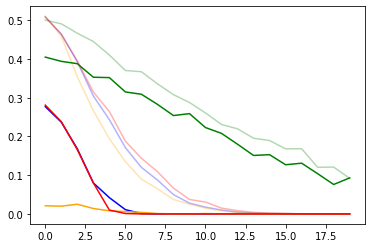

In [ ]:
plt.plot(train_logit, c='blue')
plt.plot(test_logit, alpha=0.3, c='blue')
plt.plot(train_SVM, c='orange')
plt.plot(test_SVM, alpha=0.3, c='orange')
plt.plot(train_nTARP, c='green')
plt.plot(test_nTARP, alpha=0.3, c='green')
plt.plot(train_linear_SVM, c='red')
plt.plot(test_linear_SVM, alpha=0.3, c='red')

Plot the results for the generalization gap:

<ErrorbarContainer object of 3 artists>

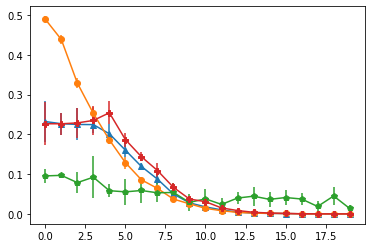

In [ ]:
plt.errorbar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], gap_logit, gap_logit_deviation, linestyle='solid', marker='^')
plt.errorbar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], gap_SVM, gap_SVM_deviation, linestyle='solid', marker='o')
plt.errorbar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], gap_nTARP, gap_nTARP_deviation, linestyle='solid', marker='p')
plt.errorbar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], gap_linear_SVM, gap_linear_SVM_deviation, linestyle='solid', marker='P')